## feeder concept: cutter + barges

This notebook shows how to implement a basic feeder concept for a cutter suction dredge working with multiple barges.

In [1]:
import datetime, time
import simpy

import shapely.geometry
import pandas as pd

import openclsim.core as core
import openclsim.model as model
from openclsim.utils import flatten, export_concepts, export_activities
from openclsim.plot import get_step_chart, get_gantt_chart, get_log_dataframe, get_ranges_dataframe
import numpy as np

In [2]:
cutter_name    = 'Cutter T'
barge_names    = ['Carrier A','Carrier B','Carrier C',
                  'Barge I','Barge II','Barge III',
                  'Extra 1', 'Extra 2', 'Extra 3']
vessel_cost     = {'Carrier A':6000,'Carrier B':6000,'Carrier C':6000,
                  'Barge I':5000,'Barge II':5000,'Barge III':5000,
                  'Extra 1':4000, 'Extra 2':4000, 'Extra 3':4000,
                  'Cutter T':25000} # EUR/day
# vessel_amount and vessel_durations are random within a range,
# to mimic respectively material density variations
# and metocean workability conditions and traffic density.

amount_range = [4,6]
duration_range = [2000,3000]

from_site_name = 'Trench'
to_site_name   = 'Reclamation'

In [3]:
Site = type(
    "Site",
    (
        core.Identifiable,
        core.Log,
        core.Locatable,
        core.HasContainer,
        core.HasResource,
    ),
    {},
)
TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        core.Identifiable,
        core.Log,
        core.ContainerDependentMovable,
        core.Processor,
        core.HasResource,
    ),
    {},
)

In [4]:
def run(NR_BARGES, total_amount, simulation_start=0):
    my_env = simpy.Environment(initial_time=simulation_start)
    registry = {}

    location_from_site = shapely.geometry.Point(4.18055556, 52.18664444)
    location_to_site = shapely.geometry.Point(4.25222222, 52.11428333)
    
    sites = {}

    data_from_site = {"env": my_env,
                      "name": from_site_name,
                      "geometry": location_from_site,
                      "capacity": total_amount,
                      "level": total_amount,
                      "nr_resources":1
                     }
    from_site =  Site(**data_from_site)
    sites[from_site_name] = from_site


    location_to_site = shapely.geometry.Point(4.25222222, 52.11428333)
    data_to_site = {"env": my_env,
                    "name": to_site_name,
                    "geometry": location_to_site,
                    "capacity": total_amount,
                    "level": 0,
                    "nr_resources":4
                   }
    to_site = Site(**data_to_site)
    sites[to_site_name] = to_site

    vessels = {}

    for i in range(NR_BARGES):
        vessel_name = barge_names[i]
        vessels[vessel_name] = TransportProcessingResource(
            env=my_env,
            name=vessel_name,
            geometry=location_from_site, 
            capacity=10,
            compute_v=lambda x: 10
        )
    cutter = TransportProcessingResource(
        env=my_env,
        name=cutter_name,
        geometry=location_from_site, 
        capacity=10,
        compute_v=lambda x: 10
    )
    vessels[cutter_name] = cutter
    

    activities = {}
    for i in range(NR_BARGES):
        vessel_name = barge_names[i]
        amount = np.random.randint(amount_range[0], amount_range[1]) # handle loading
        duration=np.random.randint(duration_range[0], duration_range[1]) # sailing and unloading

        requested_resources={}
        activities[f"activity{i}"] = model.WhileActivity(
            env=my_env,
            name=f"while_sequential_activity_subcycle {vessel_name}",
            registry=registry,
            sub_processes=[model.SequentialActivity(
                env=my_env,
                name=f"sequential_activity_subcycle {vessel_name}",
                registry=registry,
                sub_processes=[
# cannot be linked to a vessel as it is neither mover, processor, origin or destination
#                     model.BasicActivity(
#                         env=my_env,
#                         name=f"basic activity:"+vessels[vessel_name].name,
#                         registry=registry,
#                         duration=duration,
#                         additional_logs=[vessels[vessel_name]],
#                     ),
                    model.MoveActivity(
                        env=my_env,
                        name=f"sailing empty:"+vessels[vessel_name].name,
                        registry=registry,
                        mover=vessels[vessel_name],
                        destination=from_site,
                        duration=duration,
                    ),
                    model.ShiftAmountActivity(
                        env=my_env,
                        name=f"loading:"+vessels[vessel_name].name,
                        registry=registry,
                        processor=cutter,
                        origin=from_site,
                        destination=vessels[vessel_name],
                        amount=amount,
                        duration=500*amount,
                        requested_resources=requested_resources,
                    ),
                    model.MoveActivity(
                        env=my_env,
                        name=f"sailing full:"+vessels[vessel_name].name,
                        registry=registry,
                        mover=vessels[vessel_name],
                        destination=to_site,
                        duration=duration,
                    ),
                    model.ShiftAmountActivity(
                        env=my_env,
                        name=f"unloading:"+vessels[vessel_name].name,
                        registry=registry,
                        processor=vessels[vessel_name],
                        origin=vessels[vessel_name],
                        destination=to_site,
                        amount=amount,
                        duration=duration,
                        requested_resources=requested_resources,
                    ),
                ],
            )],
            condition_event=[
                {
                    "type": "container", 
                    "concept": to_site, 
                    "state": "full",
                    "id_":"default_reservations"
                }
            ],
        )

    model.register_processes(list(activities.values()))
    my_env.run()
    
    return {
        "vessels": vessels,
        "activities":activities,
        "sites":sites
    }


# Example plots with 3 barges

In [5]:
%%time
nbarges = len(barge_names)
assert len(set(barge_names))==len(barge_names), 'barge_names need to be unique'
total_amount = 100
simulation_start = 0
res = run(3,total_amount, simulation_start)

vessels = res['vessels']
sites = res['sites']
activities = res['activities']

cutter = vessels[cutter_name]
to_site = sites[to_site_name]
from_site = sites[from_site_name]

CPU times: user 40.9 ms, sys: 31.2 ms, total: 72.1 ms
Wall time: 65 ms


In [6]:
fig = get_gantt_chart(vessels, id_map=activities)

In [7]:
fig = get_gantt_chart([from_site, to_site, cutter], id_map=activities)

Plot only activities whose namespace (first letters) matches load*

In [8]:
flat = pd.DataFrame(flatten(activities))
loading = list(flat[flat['ActivityName'].str.startswith('loading')]['activity'].values)
fig = get_gantt_chart(loading)

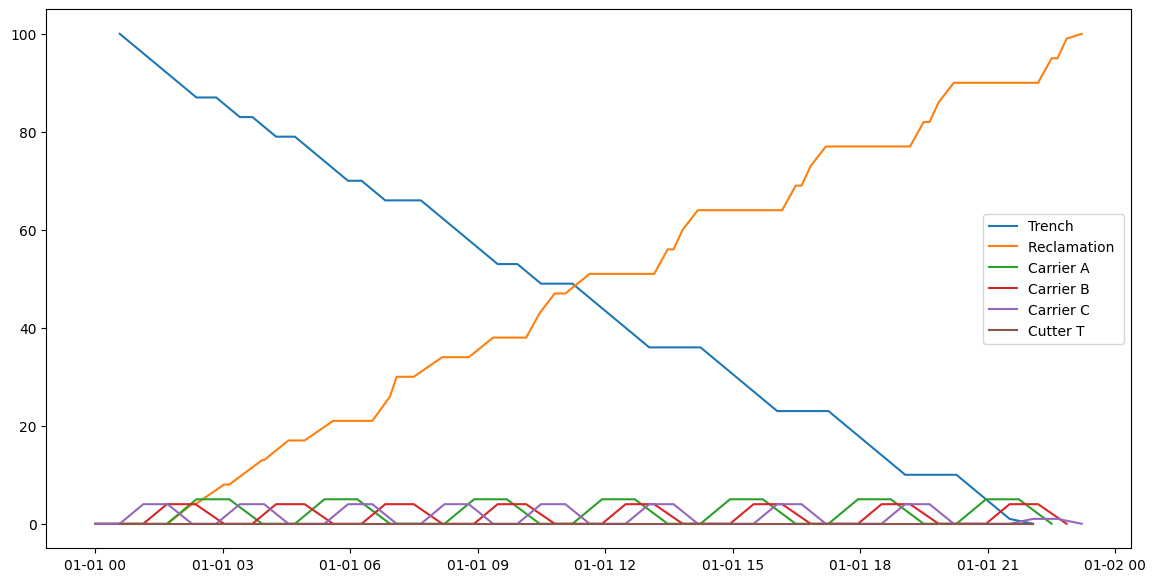

In [9]:
fig = get_step_chart([from_site, to_site, *vessels.values()])

In [10]:
def occupancy_analysis(vessels, cutter_name, total_amount, vessel_cost):
    """Model specific calculation of vessel occupancy"""
    
    data = []
    
    for i, vessel_name in enumerate(vessels):
        vessel = vessels[vessel_name]

        log = get_ranges_dataframe(vessel)
        
        duration_theory = log.TimestampDt.sum()
        
        # We assume all vessels arrive JIT when they need to start,
        # and leaves immediately when they are done (so different demob times)
        # this is an overestimation of actual occupancy
        
        duration_actual = (log.TimestampStop.max() - log.TimestampStart.min()).total_seconds()
        nr_trips = len(log.groupby('trip'))
        
        if vessel.name==cutter_name:
            amount = total_amount
        else:
            amount = sum(log.groupby('trip')['ContainerLevelStop'].max())
        
        data.append({
            'name':vessel.name, 
            '# trips':nr_trips, 
            'start': log.TimestampStart.min(),
            'finish': log.TimestampStop.max(),
            'amount sum': amount,
            'duration actual': duration_actual,
            'duration theory':duration_theory,
            'cost actual':round(duration_actual*vessel_cost[vessel_name]/3600/24,0),
            'production actual':(nr_trips * amount) / (duration_actual),
            'production theory':(nr_trips * amount / (duration_theory)),
        })

    df = pd.DataFrame(data).sort_values(by=['production actual'],ascending=False)
    df['occupancy [%]'] = [round(x,1) for x in 100*df['production actual']/df['production theory']]
    df.set_index('name', inplace=True)
    
    # cutter does amount same as all barges
    assert df['amount sum'].sum()-total_amount==total_amount, 'material imbalance'
    
    return df

In [11]:
occupancy_analysis(vessels, cutter_name, total_amount, vessel_cost).sort_values(by=["name"])

,# trips,start,finish,amount sum,duration actual,duration theory,cost actual,production actual,production theory,occupancy [%]
name,,,,,,,,,,
Carrier A,7,1970-01-01 00:00:00,1970-01-01 22:30:13,35.0,81013.0,75901.0,5626.0,0.003024,0.003228,93.7
Carrier B,8,1970-01-01 00:00:00,1970-01-01 22:51:23,32.0,82283.0,73984.0,5714.0,0.003111,0.003460,89.9
Carrier C,9,1970-01-01 00:00:00,1970-01-01 23:12:49,33.0,83569.0,73593.0,5803.0,0.003554,0.004036,88.1
Cutter T,9,1970-01-01 00:34:19,1970-01-01 22:04:11,100.0,77392.0,51500.0,22394.0,0.011629,0.017476,66.5


# Compare multiple barge scenarios

In [12]:
results = []
occupancy = []
cost = []
duration = []

n_barges = range(2,len(barge_names)) # +1 at least 1 barge
for i in n_barges:
    results.append(run(i,total_amount))
    
    vessels = results[-1]['vessels']
    activities = results[-1]['activities']
    sites = results[-1]['sites']
    
    cutter = vessels[cutter_name]
    
    df = occupancy_analysis(vessels, cutter_name, total_amount, vessel_cost)
    occupancy.append(df.loc[cutter_name]['occupancy [%]'])
    cost.append(df['cost actual'].sum())
    duration.append((df['finish'].max() - df['start'].min()).total_seconds()/3600/24)
    #     display(df)
    
scenarios = {'# barges':n_barges,
             'cutter occupancy':occupancy,
             'total cost':cost,
             'total duration':duration}
scenarios = pd.DataFrame.from_dict(scenarios)
scenarios

,# barges,cutter occupancy,total cost,total duration
0,2,48.3,45098.0,1.273669
1,3,70.2,36217.0,0.916250
2,4,82.1,35346.0,0.813519
3,5,96.2,32931.0,0.692500
4,6,100.0,34161.0,0.658403
5,7,100.0,35655.0,0.649398
6,8,100.0,38723.0,0.676204


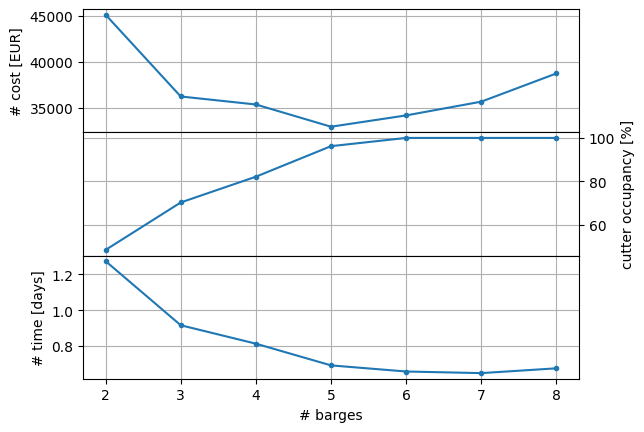

In [13]:
# plot 3 optimization criteria: cost, duration, occupancy (1/flexibility)
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
gs = fig.add_gridspec(3, hspace=0)
axs = gs.subplots(sharex=True)


axs[0].plot(scenarios['# barges'],scenarios['total cost'],'.-'), axs[0].set_ylabel('# cost [EUR]'),axs[0].grid();
# axs[0].set_xlabel('# barges');

axs[1].plot(scenarios['# barges'],scenarios['cutter occupancy'],'.-'), axs[1].set_ylabel('cutter occupancy [%]'),axs[1].grid();
# axs[1].set_xlabel('# barges');
axs[1].yaxis.set_label_position("right")
axs[1].yaxis.tick_right()

axs[2].plot(scenarios['# barges'],scenarios['total duration'],'.-'), axs[2].set_ylabel('# time [days]'),axs[2].grid();

axs[-1].set_xlabel('# barges');

In [14]:
# choose 1 scenario for further analysis and export
# many barges: close to 100% cutter config, small cost, fast delivery.
scenario_index = 2

# Visualize critical path of chosen optimal scenario

For explanation of Critical Path see notebook 30

In [15]:
from openclsim.plot.critical_path import CpLog

In [16]:
i = scenario_index
vessels = results[i]['vessels']
activities = results[i]['activities']
sites = results[i]['sites']
  
my_objects = list(vessels.values()) + list(sites.values())
my_activities = list(activities.values())
my_log = CpLog(list_objects=my_objects, list_activities=my_activities)
dependencies = my_log.get_dependencies_model_based()
# dependencies = my_log.get_dependencies_log_based()
cp = my_log.mark_critical_activities(dependencies)
occupancy = occupancy_analysis(vessels, cutter_name, total_amount, vessel_cost)

t = f'{cutter_name} occupancy: ' + str(occupancy.loc[cutter_name]['occupancy [%]']) + f'duration actual: ' +\
     str(occupancy.loc[cutter_name]['duration actual'])
fig = get_gantt_chart(concepts=my_objects, critical_path=cp, id_map=activities, title=t, legend=False, ylabel='vesels')

In [17]:
occupancy

,# trips,start,finish,amount sum,duration actual,duration theory,cost actual,production actual,production theory,occupancy [%]
name,,,,,,,,,,
Cutter T,6,1970-01-01 00:39:46,1970-01-01 17:54:36,100.0,62090.0,51000.0,17966.0,0.009663,0.011765,82.1
Barge I,6,1970-01-01 00:00:00,1970-01-01 18:51:21,30.0,67881.0,64230.0,3928.0,0.002652,0.002802,94.6
Carrier A,6,1970-01-01 00:00:00,1970-01-01 16:48:50,24.0,60530.0,54948.0,4203.0,0.002379,0.002621,90.8
Carrier B,6,1970-01-01 00:00:00,1970-01-01 17:28:22,24.0,62902.0,58296.0,4368.0,0.002289,0.002470,92.7
Carrier C,6,1970-01-01 00:00:00,1970-01-01 19:31:28,22.0,70288.0,64308.0,4881.0,0.001878,0.002053,91.5


# Export data  to BI

In [18]:
export_concepts(sites, 'site', 'sites.csv')

,siteName,siteID,siteType
0,Trench,2f3ebe81-c5a8-4eab-97f2-5e3660f309a9,<class '__main__.Site'>
1,Reclamation,e46799ae-1c5f-40ea-b541-b4e3caa68601,<class '__main__.Site'>


In [19]:
export_concepts(vessels, 'vessel', 'vessels.csv')

,vesselName,vesselID,vesselType
0,Carrier A,0f6270f9-f26d-4a4f-ab2e-f8ea9b386d84,<class '__main__.TransportProcessingResource'>
1,Carrier B,f0c96e64-dca6-4a7a-8a2b-4bd294d80d7c,<class '__main__.TransportProcessingResource'>
2,Carrier C,db94ce4f-c699-4989-b370-52b1b15aae7a,<class '__main__.TransportProcessingResource'>
3,Barge I,91afcbba-70f5-4619-8f4f-a6df010da33c,<class '__main__.TransportProcessingResource'>
4,Cutter T,659f8cc8-5791-4eb4-93b8-3622849ea169,<class '__main__.TransportProcessingResource'>


In [20]:
activities_flat = export_activities(activities, 'activities.csv', [*sites.values(), *vessels.values()])
# activities_flat

In [21]:
set(activities_flat['MoverName'])

{'', 'Barge I', 'Carrier A', 'Carrier B', 'Carrier C'}

In [22]:
set(activities_flat['ProcessorName'])

{'', 'Barge I', 'Carrier A', 'Carrier B', 'Carrier C', 'Cutter T'}

In [23]:
set(activities_flat['OriginName'])

{'', 'Barge I', 'Carrier A', 'Carrier B', 'Carrier C', 'Trench'}

In [24]:
set(activities_flat['DestinationName'])

{'', 'Barge I', 'Carrier A', 'Carrier B', 'Carrier C', 'Reclamation', 'Trench'}

In [25]:
set(activities_flat['ActivityClass'])

{'MoveActivity', 'SequentialActivity', 'ShiftAmountActivity', 'WhileActivity'}

In [26]:
# set(activities_flat['ActivityName'])

# Expand logged activity instances to analyse occupancy properly

In [27]:
def export_ranges(all_act_flat, ofile = None, concept_name=None):
    
    if concept_name:
        logmask = (all_act_flat['ProcessorName']==concept_name) | \
                  (all_act_flat['MoverName']==concept_name)  | \
                  (all_act_flat['OriginName']==concept_name)  | \
                  (all_act_flat['DestinationName']==concept_name) 

        all_act_flat = all_act_flat[logmask]
    
    li = []
    for i, rowi in all_act_flat.iterrows():
        log = get_ranges_dataframe(rowi['activity'])
        log.rename(columns={'Activity':'ActivityID'}, inplace=True)
        li.append(log)
    ActivityRanges = pd.concat(li)
    
    ActivityRanges = ActivityRanges.merge(all_act_flat[['ActivityID', 'ActivityName', 'ActivityClass']], on='ActivityID', how='left')
    
    keys  = ['trip',
             'ActivityID','ActivityName','ActivityClass',
             'TimestampStart','TimestampStop','TimestampDt']
    if concept_name:
        ActivityRanges['ConceptName'] = concept_name
        keys+=['ConceptName']
        
    if ofile:
        ActivityRanges.to_csv(ofile, columns = keys, index=False)
    
    return ActivityRanges.sort_values(by=["TimestampStart"])

In [28]:
VesselActivitiesLog = export_ranges(activities_flat, 'instances.csv')

In [29]:
VesselActivitiesLog = export_ranges(activities_flat, 'instances_cutter.csv', cutter_name)
VesselActivitiesLog

,TimestampStart,trip,TimestampStop,ActivityID,TimestampDt,ActivityName,ActivityClass,ConceptName
0,1970-01-01 00:39:46,1,1970-01-01 01:13:06,a71b9fb2-969b-4c53-a4ae-3c4f4146f7f4,2000.0,loading:Carrier A,ShiftAmountActivity,Cutter T
6,1970-01-01 01:13:06,1,1970-01-01 01:46:26,09040c24-1887-4ae9-9f1b-d3eddf4104b0,2000.0,loading:Carrier B,ShiftAmountActivity,Cutter T
18,1970-01-01 01:46:26,1,1970-01-01 02:28:06,19ae16b1-5c21-42af-972f-a666a49c9f9d,2500.0,loading:Barge I,ShiftAmountActivity,Cutter T
12,1970-01-01 02:28:06,1,1970-01-01 03:01:26,2c37934a-bc1f-4dc6-92b5-a9ced766a773,2000.0,loading:Carrier C,ShiftAmountActivity,Cutter T
1,1970-01-01 03:12:24,2,1970-01-01 03:45:44,a71b9fb2-969b-4c53-a4ae-3c4f4146f7f4,2000.0,loading:Carrier A,ShiftAmountActivity,Cutter T
7,1970-01-01 03:55:02,2,1970-01-01 04:28:22,09040c24-1887-4ae9-9f1b-d3eddf4104b0,2000.0,loading:Carrier B,ShiftAmountActivity,Cutter T
19,1970-01-01 04:44:51,2,1970-01-01 05:26:31,19ae16b1-5c21-42af-972f-a666a49c9f9d,2500.0,loading:Barge I,ShiftAmountActivity,Cutter T
13,1970-01-01 05:26:44,2,1970-01-01 06:00:04,2c37934a-bc1f-4dc6-92b5-a9ced766a773,2000.0,loading:Carrier C,ShiftAmountActivity,Cutter T
2,1970-01-01 06:00:04,3,1970-01-01 06:33:24,a71b9fb2-969b-4c53-a4ae-3c4f4146f7f4,2000.0,loading:Carrier A,ShiftAmountActivity,Cutter T
8,1970-01-01 06:36:58,3,1970-01-01 07:10:18,09040c24-1887-4ae9-9f1b-d3eddf4104b0,2000.0,loading:Carrier B,ShiftAmountActivity,Cutter T


In [30]:
flat = pd.DataFrame(flatten(activities))
loading = list(flat[flat['ActivityName'].str.startswith('loading')]['activity'].values)
fig = get_gantt_chart(loading)